# How to use the models we trained

In [1]:
# !pip install -U opencv-python tabula-py pdfquery

In [1]:
%load_ext autoreload
%autoreload 2

import os, numpy, glob, collections, random, \
    shutil, pandas, time, subprocess, itertools, \
    cv2, tempfile, scipy, pdfquery
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID" # see issue #152
os.environ["CUDA_VISIBLE_DEVICES"]= ""

from PIL import Image
from IPython.display import display, SVG
from joblib import Parallel, delayed

import matplotlib.pyplot as plt
%pylab inline

from keras import backend as K
from keras.models import load_model
from keras.objectives import binary_crossentropy
from vis.visualization import visualize_activation

import tabula

Populating the interactive namespace from numpy and matplotlib


/root/.pyenv/versions/3.6.0/lib/python3.6/site-packages/IPython/core/magics/pylab.py:160: UserWarning: pylab import has clobbered these variables: ['random']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"
Using TensorFlow backend.


In [2]:
smooth = 1e-12

def dice_coef(y_true, y_pred, channels=None):
    intersection = K.sum(y_true * y_pred, axis=[0, 1, 2])
    union = K.sum(y_true + y_pred, axis=[0, 1, 2])
    dice = (intersection + smooth) / (union - intersection + smooth)
    if not channels is None:
        return K.mean(K.gather(dice, channels))
    else:
        return K.mean(dice)

    
def dice_coef_0(y_true, y_pred):
    return dice_coef(y_true, y_pred, channels=[0])


def dice_coef_1(y_true, y_pred):
    return dice_coef(y_true, y_pred, channels=[1])


def dice_coef_01(y_true, y_pred):
    return dice_coef(y_true, y_pred, channels=[0, 1])


def dice_coef_loss(y_true, y_pred):
    return -dice_coef(y_true, y_pred)


def dice_ce_loss(y_true, y_pred):
    return -K.log(dice_coef(y_true, y_pred)) + binary_crossentropy(y_pred, y_true)

# segmentation_model = load_model('./models/contours.h5', custom_objects=dict(dice_coef_loss=dice_coef_loss))
segmentation_model = load_model('./models/bt1.h5', custom_objects=dict(dice_coef_loss=dice_coef_loss,
                                                                       dice_coef=dice_coef,
                                                                       dice_ce_loss=dice_ce_loss,
                                                                       dice_coef_0=dice_coef_0,
                                                                       dice_coef_1=dice_coef_1,
                                                                       dice_coef_01=dice_coef_01))

/root/.pyenv/versions/3.6.0/lib/python3.6/site-packages/keras/models.py:281: UserWarning: Error in loading the saved optimizer state. As a result, your model is starting with a freshly initialized optimizer.
  warnings.warn('Error in loading the saved optimizer '


In [182]:
def arr_to_img(arr):
#     return Image.fromarray(numpy.clip(arr * 255, 0, 255).astype('uint8'))
    return Image.fromarray((arr * 255).astype('uint8'))


def arr3_to_img(arr):
    arr = numpy.rollaxis(arr, 0, 2).reshape((arr.shape[1], arr.shape[0] * arr.shape[2])+arr.shape[3:])
    return arr_to_img(arr)


def to_grayscale(arr):
    return arr.mean(axis=-1)


def identity(x):
    return x


def rgba_to_rgb(image, color=(255, 255, 255)):
    image.load()  # needed for split()
    background = Image.new('RGB', image.size, color)
    background.paste(image, mask=image.split()[3])  # 3 is the alpha channel
    return background


def la_to_l(image, color=255):
    image.load()  # needed for split()
    background = Image.new('L', image.size, color)
    background.paste(image, mask=image.split()[-1])  # 3 is the alpha channel
    return background


def load_image_to_array(fname, proc=identity, mode=None):
    img = Image.open(fname)
    if not mode is None and img.mode != mode:
        if img.mode == 'LA':
            img = la_to_l(img)
        elif img.mode == 'RGBA':
            img = rgba_to_rgb(img)
        img = img.convert(mode)
    return proc(numpy.array(img))


def binarize_tensor(arr, threshold=0.7):
    return numpy.where(arr >= threshold, 1, 0)


def read_images_to_tensor(filenames, n_jobs=20, proc=identity, mode='RGB'):
    data = list(Parallel(n_jobs=n_jobs)(delayed(load_image_to_array)(fname, proc=proc, mode=mode)
                                        for fname in filenames))
    return numpy.stack(data).astype('float32') / 255.0


def segment_images(model, image_fnames, output_threshold=0.8, **read_kwargs):
    img_data = read_images_to_tensor(image_fnames, **read_kwargs)
    return binarize_tensor(model.predict(img_data).reshape(img_data.shape[:-1]),
                           threshold=output_threshold)


WINDOW_SIZE = (500, 500)
STRIDE = (50, 50)
OUT_SCALE_TO = (256, 256)
OUT_MODE = 'L'
ROTATIONS = (0,) #, 90, 180, 270)
DENSITY = 72
PIXELS_TO_POINTS_FACTOR = 1 # DENSITY / 72.0 # convert does not respect density and resample when converting to png


def pdf_to_pages(in_file, out_dir, pages=None):
    if pages is None:
        subprocess.check_call(['convert',
                               '-define', 'pdf:use-cropbox=true',
                               in_file,
                               '-density', str(DENSITY),
                               '-resample', '{0}x{0}'.format(DENSITY),
                               os.path.join(out_dir, '%04d.png')])
    else:
        for page in pages:
            subprocess.check_call(['convert',
                                   '-define', 'pdf:use-cropbox=true',
                                   '{}[{}]'.format(in_file, page),
                                   '-density', str(DENSITY),
                                   '-resample', '{0}x{0}'.format(DENSITY),
                                   os.path.join(out_dir, '{:04d}.png'.format(page))])
    result = list(glob.glob(os.path.join(out_dir, '*.png')))
    result.sort()
    return result


def augment_image_deterministic(fname, out_dir):
    out_i = 0
    base_fname = os.path.splitext(os.path.basename(fname))[0]
    src_img = Image.open(fname).convert('RGB').convert(OUT_MODE)

    offset_gen = itertools.product(range(0,
                                         src_img.size[0] - WINDOW_SIZE[0],
                                         STRIDE[0]),
                                   range(0,
                                         src_img.size[1] - WINDOW_SIZE[1],
                                         STRIDE[1]))
    for x_off, y_off in offset_gen:
        new_image = src_img.crop((x_off,
                                  y_off,
                                  x_off + WINDOW_SIZE[0],
                                  y_off + WINDOW_SIZE[1]))
        new_image.thumbnail(OUT_SCALE_TO)
        for angle in ROTATIONS:
            out_fname = os.path.join(out_dir,
                                     '_'.join((base_fname,
                                               str(out_i))) + '.png')
            new_image.rotate(angle).save(out_fname)
            yield (x_off, y_off, angle, out_fname)
            out_i += 1


# Network outputs:
# (Footer, Header, Body) - hbf
# (Text - Header+Footer, Body) - bt


def process_page(segm_model, full_image_fname, out_dir, mask_threshold=0.5, min_contour_area=100, read_mode='L', read_proc=identity, take_channels=2):
    transformations = list(augment_image_deterministic(full_image_fname, out_dir))
    transformed_images = numpy.expand_dims(read_images_to_tensor([f for _, _, _, f in transformations],
                                                                 mode=read_mode,
                                                                 proc=read_proc),
                                           -1)

    partial_masks = segm_model.predict(transformed_images)
    if isinstance(partial_masks, list):
        partial_masks = partial_masks[0]

    page_image = Image.open(full_image_fname).convert('RGB').convert(OUT_MODE)
    print('page size', page_image.size)

    aggregated_mask = numpy.zeros((page_image.size[1], page_image.size[0], partial_masks.shape[-1]),
                                  dtype='float32')
    norm = numpy.zeros_like(aggregated_mask)
    for (x_off, y_off, angle, _), mask_pixels in zip(transformations, partial_masks):
        mask_width = min(WINDOW_SIZE[0], aggregated_mask.shape[1] - x_off)
        mask_height = min(WINDOW_SIZE[1], aggregated_mask.shape[0] - y_off)

        mask = arr_to_img(mask_pixels)
        mask = mask.rotate(-angle).resize((mask_width, mask_height), Image.BILINEAR)
        mask_pixels = numpy.array(mask)
        aggregated_mask[y_off:y_off+mask_pixels.shape[1],
                        x_off:x_off+mask_pixels.shape[0]] += mask_pixels

        norm[y_off:y_off+mask_pixels.shape[1],
             x_off:x_off+mask_pixels.shape[0], :] += 1
    aggregated_mask = numpy.nan_to_num(aggregated_mask / norm) / 255
    nan_mask = numpy.where(aggregated_mask.sum(-1) < 1e-3)
    aggregated_mask[nan_mask[0], nan_mask[1], -1] = 1

#     display(arr_to_img(aggregated_mask))

    # renormalize with softmax
    aggregated_mask = numpy.exp(aggregated_mask)
    aggregated_mask /= numpy.expand_dims(aggregated_mask.sum(-1), -1)
    
#     display(arr_to_img(aggregated_mask))
    
    # binarize by argmax
    max_idx = aggregated_mask.argmax(axis=-1)
    aggregated_mask_bin = numpy.zeros_like(aggregated_mask)
    for channel in range(aggregated_mask.shape[-1]):
        mask = numpy.where(max_idx == channel)
        aggregated_mask_bin[mask[0], mask[1], channel] = 1
#     display(arr_to_img(aggregated_mask_bin))

#     aggregated_mask = binarize_tensor(aggregated_mask, mask_threshold * 255.0)

    contours = [(channel,
                 cv2.findContours((aggregated_mask_bin[:, :, channel]).astype('uint8'),
                                  cv2.RETR_LIST,
                                  cv2.CHAIN_APPROX_SIMPLE)[1])
                for channel in range(take_channels)]
    result = []
    demo_mask = numpy.zeros(aggregated_mask_bin.shape[:-1] + (3,),
                            dtype='uint8')
    for channel, cur_contours in contours:
        for cnt in cur_contours:
            if cv2.contourArea(cnt) < min_contour_area:
                continue
            x, y, w, h = cv2.boundingRect(cnt)
            result.append((channel, numpy.array([y, x, y+h, x+w]) * PIXELS_TO_POINTS_FACTOR))
            color = [0] * 3
            color[channel] = 255
            cv2.drawContours(demo_mask,
                             [numpy.array([(x, y),
                                            (x + w, y),
                                            (x + w, y + h),
                                            (x, y + h)])],
                             -1,
                             tuple(color),
                             cv2.FILLED)

    demo_mask = arr_to_img(demo_mask.astype('float32') / 255.0)
    display(Image.blend(page_image.convert('RGB'), demo_mask, 0.5))
    return result


def extract_table_with_tabula(pdf_file, page_no, box):
    return tabula.read_pdf(pdf_file, guess=False, pages=page_no, area=tuple(box))


# CORNDER_COORDS_IDX = [(0, 1), (0, 3), (2, 1), (2, 3)]
# def box_to_corner_coords(box):
#     return [(box[i], box[j]) for i, j in CORNDER_COORDS_IDX]


# def two_box_distance(a, b):
#     point_pairs = itertools.product(box_to_corner_coords(a),
#                                     box_to_corner_coords(b))
#     distances = map(scipy.spatial.distance.euclidean, point_pairs)
#     return min(distances)


def rect_distance(a, b):
    y1, x1, y1b, x1b = a
    y2, x2, y2b, x2b = b
    left = x2b < x1
    right = x1b < x2
    bottom = y2b < y1
    top = y1b < y2
    if top and left:
        return scipy.spatial.distance.euclidean((x1, y1b), (x2b, y2))
    elif left and bottom:
        return scipy.spatial.distance.euclidean((x1, y1), (x2b, y2b))
    elif bottom and right:
        return scipy.spatial.distance.euclidean((x1b, y1), (x2, y2b))
    elif right and top:
        return scipy.spatial.distance.euclidean((x1b, y1b), (x2, y2))
    elif left:
        return x1 - x2b
    elif right:
        return x2 - x1b
    elif bottom:
        return y1 - y2b
    elif top:
        return y2 - y1b
    else:             # rectangles intersect
        return 0.


def convert_coords_to_pq(box, cropbox):
    ul_y, ul_x, br_y, br_x = box
    x_off, _, _, page_height = cropbox
    return numpy.array([ul_x + x_off, page_height - br_y, br_x + x_off, page_height - ul_y])


def convert_coords_from_pq(box, cropbox):
    bl_x, bl_y, ur_x, ur_y = box
    x_off, _, _, page_height = cropbox
    return numpy.array([page_height - ur_y, bl_x - x_off, page_height - bl_y, ur_x - x_off])


TableInfo = collections.namedtuple('TableInfo',
                                   'page surrounding_text_boxes surrounding_texts body_box body success'.split(' '))


def process_pdf(segm_model, in_file, tmp_dir_prefix='/tmp', return_only_successful=True, pad=2, pages=None, max_text_distance=20):
    result = []
    parsed_pdf = pdfquery.PDFQuery(in_file)
    parsed_pdf.load()
    with tempfile.TemporaryDirectory(dir=tmp_dir_prefix) as wd:
        page_filenames = pdf_to_pages(in_file, wd, pages=pages)

        for page_fname in page_filenames:
            page_i = int(os.path.splitext(os.path.basename(page_fname))[0])
            page = parsed_pdf.get_page(page_i)
            print('id', page_i, page.pageid)
#             page_crop = page.cropbox
#             offsets = numpy.array([-page_crop[1] - pad, -page_crop[0] - pad, -page_crop[1] + pad, -page_crop[0] + pad])
            offsets = numpy.array([-pad, -pad, pad, pad])

            boxes = process_page(segm_model, page_fname, wd, mask_threshold=0.5)

            this_page_result = []

            bodies = [box + offsets for channel, box in boxes if channel == 1]
            for body_box in bodies:
                body = extract_table_with_tabula(in_file, page_i + 1, body_box)
                table_info = TableInfo(page_i,
                                       [],
                                       [],
                                       body_box,
                                       body,
                                       (not body is None) and (numpy.prod(body.shape) > 1))
                if table_info.success or not return_only_successful:
                    this_page_result.append(table_info)

                if table_info.success:
                    display(body)

            if len(this_page_result) > 0:
                surrounding_texts = [box + offsets for channel, box in boxes if channel == 0]
                for text_box in surrounding_texts:
                    print('src box', text_box)
                    print('src conv', convert_coords_to_pq(text_box, page.cropbox))
                    text_query = 'LTPage[pageid="{}"] :in_bbox("{},{},{},{}")'.format(page_i + 1,
                                                                                      *convert_coords_to_pq(text_box,
                                                                                                            page.cropbox))
                    print(text_query)
                    query_res = parsed_pdf.pq(text_query)
                    text = query_res.text()
                    if not text:
                        continue
                    print('found box', query_res[0].layout.bbox)
                    print('conv back', convert_coords_from_pq(query_res[0].layout.bbox, page.cropbox))
                    print('cropbox', page.cropbox)
                    print(text)
                    distances_to_tables = [rect_distance(text_box, table.body_box)
                                           for table in this_page_result]
                    closest = numpy.argmin(distances_to_tables)
                    if distances_to_tables[closest] < max_text_distance:
                        table = this_page_result[closest]
                        table.surrounding_text_boxes.append(text_box)
                        table.surrounding_texts.append(text)

            result.extend(this_page_result)
    return result

## Vis

id 0 196


/root/.pyenv/versions/3.6.0/lib/python3.6/site-packages/PIL/Image.py:888: UserWarning: Palette images with Transparency   expressed in bytes should be converted to RGBA images
  'to RGBA images')


page size (595, 793)


/root/.pyenv/versions/3.6.0/lib/python3.6/site-packages/ipykernel_launcher.py:150: RuntimeWarning: invalid value encountered in true_divide


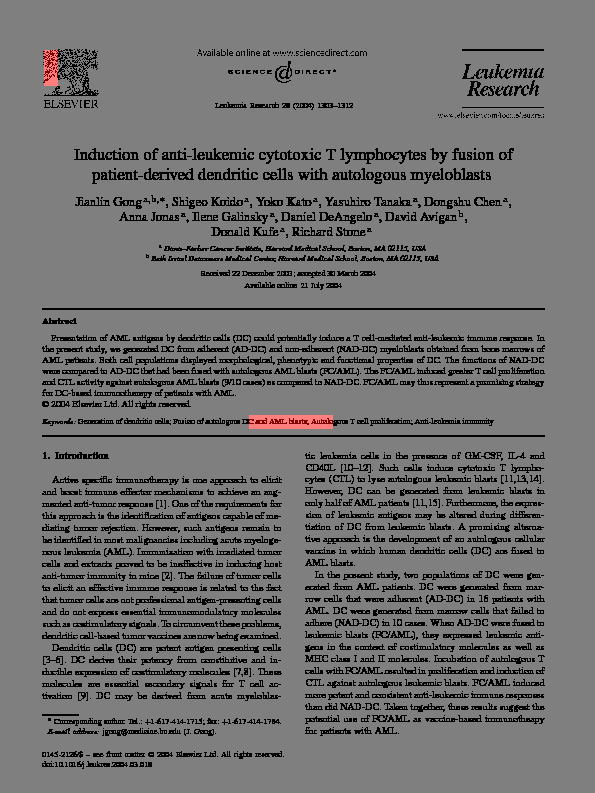

id 1 1
page size (595, 793)


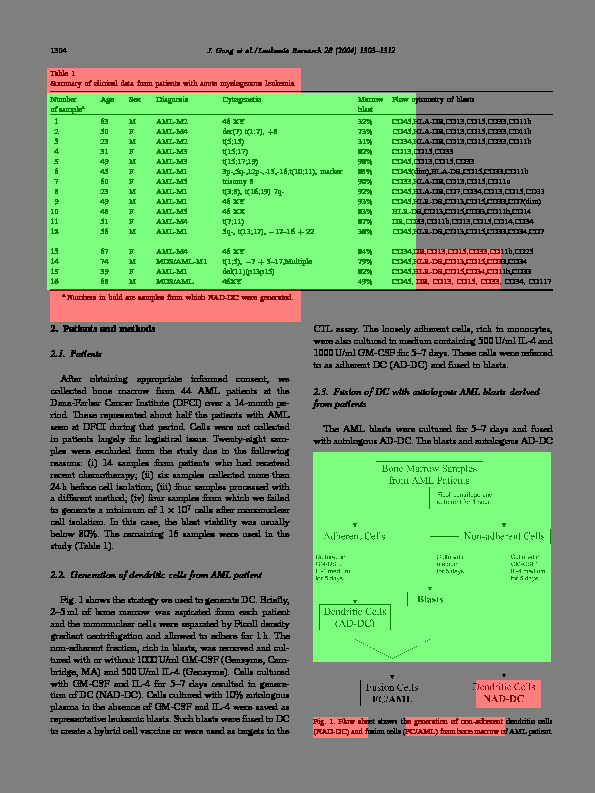

,Number,Age,Sex,Diagnosis,Cytogenetic,Unnamed: 5,Marrow,Flow c
0,of samplea,NaN,NaN,NaN,NaN,NaN,blast,NaN
1,1,63.0,M,AML-M2,46 XY,NaN,32%,"CD45,"
2,2,50.0,F,AML-M4,"der(7) t(1:7), +8",NaN,73%,"CD45,"
3,3,23.0,M,AML-M2,t(5;15),NaN,31%,"CD34,"
4,4,31.0,F,AML-M3,t(15;17),NaN,82%,"CD13,"
5,5,49.0,M,AML-M3,t(15;17;19),NaN,98%,"CD45,"
6,6,45.0,F,AML-M1,"3p-,5q-,12p-,-15,-16,t(10;11),",marker,88%,CD45(
7,7,60.0,F,AML-M5,trisomy 8,NaN,90%,"CD33,"
8,8,23.0,M,AML-M1,"t(3;8), t(16;19) 7q-",NaN,92%,"CD45,"
9,9,49.0,M,AML-M1,46 XY,NaN,93%,"CD45,"


src box [715 404 737 506]
src conv [446 103 548 125]
LTPage[pageid="2"] :in_bbox("446,103,548,125")
src box [715 311 739 369]
src conv [353 101 411 125]
LTPage[pageid="2"] :in_bbox("353,101,411,125")
src box [678 474 709 542]
src conv [516 131 584 162]
LTPage[pageid="2"] :in_bbox("516,131,584,162")
src box [287  48 323 302]
src conv [ 90 517 344 553]
LTPage[pageid="2"] :in_bbox("90,517,344,553")
found box (104.4073, 538.7596883, 335.0894061, 548.7562624)
conv back [ 291.2437376   62.4073     301.2403117  293.0894061]
cropbox [42, 47, 637, 840]
a Numbers in bold are samples from which NAD-DC were generated. a Numbers in bold are samples from which NAD-DC were generated.
src box [247 397 290 502]
src conv [439 550 544 593]
LTPage[pageid="2"] :in_bbox("439,550,544,593")
src box [ 66  45  95 302]
src conv [ 87 745 344 774]
LTPage[pageid="2"] :in_bbox("87,745,344,774")
found box (92.4521, 752.3947846, 336.6479938999999, 771.2520412)
conv back [  68.7479588   50.4521      87.6052154  294.647

/root/.pyenv/versions/3.6.0/lib/python3.6/site-packages/ipykernel_launcher.py:150: RuntimeWarning: invalid value encountered in true_divide


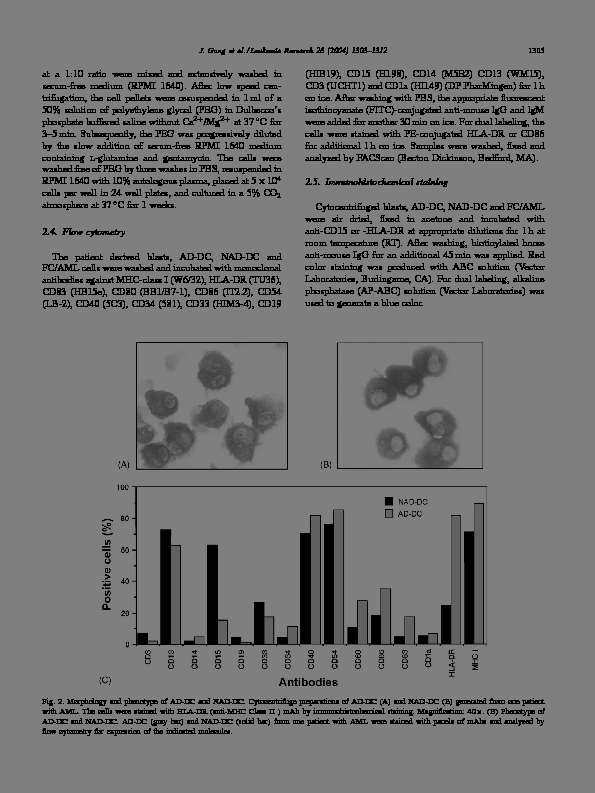

id 3 13
page size (595, 793)


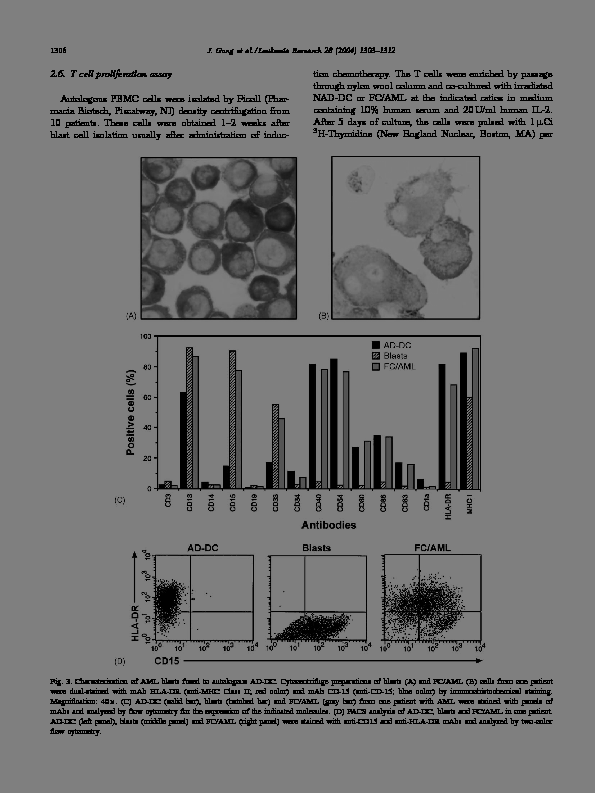

id 4 18


/root/.pyenv/versions/3.6.0/lib/python3.6/site-packages/PIL/Image.py:888: UserWarning: Palette images with Transparency   expressed in bytes should be converted to RGBA images
  'to RGBA images')


page size (595, 793)


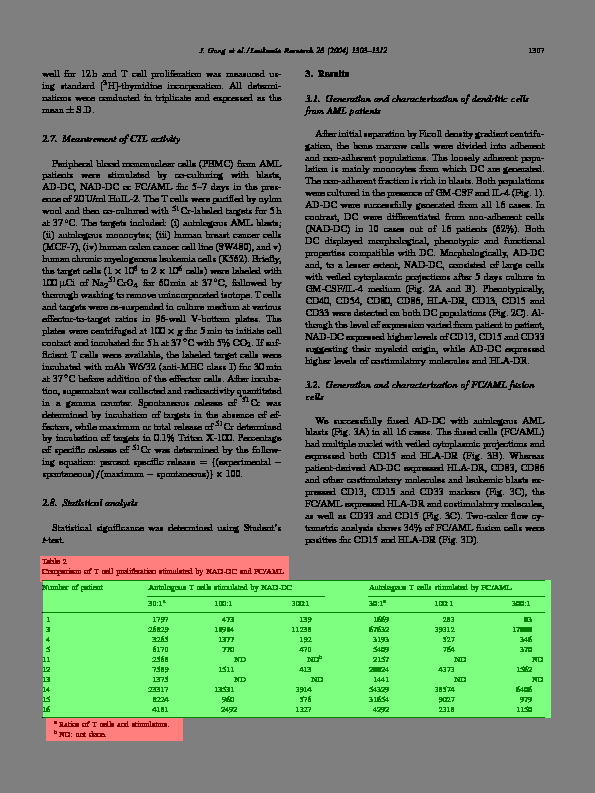

,Number,of,patient,Autologous,T,cells,stimulated by NAD-DC,Autologous.1,T.1,cells.1,stimulated by FC/AML,Unnamed: 11
0,NaN,NaN,NaN,30:1a,NaN,NaN,100:1 300:1,30:1a,NaN,NaN,100:1,300:1
1,1.0,NaN,NaN,1797,NaN,NaN,473 139,1669,NaN,NaN,283,83
2,3.0,NaN,NaN,26829,NaN,NaN,18984 11238,67632,NaN,NaN,39312,17888
3,4.0,NaN,NaN,3265,NaN,NaN,1377 192,3193,NaN,NaN,527,346
4,5.0,NaN,NaN,6170,NaN,NaN,770 470,5409,NaN,NaN,764,370
5,11.0,NaN,NaN,2568,NaN,NaN,ND NDb,2157,NaN,NaN,ND,ND
6,12.0,NaN,NaN,7589,NaN,NaN,1511 413,28824,NaN,NaN,4373,1562
7,13.0,NaN,NaN,1375,NaN,NaN,ND ND,1441,NaN,NaN,ND,ND
8,14.0,NaN,NaN,23317,NaN,NaN,13531 3914,54329,NaN,NaN,38574,6406
9,15.0,NaN,NaN,8224,NaN,NaN,960 576,31654,NaN,NaN,9027,979


src box [713  44 742 184]
src conv [ 86  98 226 127]
LTPage[pageid="5"] :in_bbox("86,98,226,127")
found box (96.2881, 101.01988829999999, 211.29217470000003, 120.9791624)
conv back [ 719.0208376   54.2881     738.9801117  169.2921747]
cropbox [42, 47, 637, 840]
a Ratios of T cells and stimulators. b ND: not done. a Ratios of T cells and stimulators. b ND: not done.
src box [586 455 596 511]
src conv [497 244 553 254]
LTPage[pageid="5"] :in_bbox("497,244,553,254")
src box [580 446 589 502]
src conv [488 251 544 260]
LTPage[pageid="5"] :in_bbox("488,251,544,260")
src box [554  38 583 290]
src conv [ 80 257 332 286]
LTPage[pageid="5"] :in_bbox("80,257,332,286")
found box (84.3329, 263.8713633, 326.1297938000001, 282.72861989999996)
conv back [ 557.2713801   42.3329     576.1286367  284.1297938]
cropbox [42, 47, 637, 840]
Table 2 Comparison of T cell proliferation stimulated by NAD-DC and FC/AML Table 2 Comparison of T cell proliferation stimulated by NAD-DC and FC/AML
id 5 32
page size (5

/root/.pyenv/versions/3.6.0/lib/python3.6/site-packages/ipykernel_launcher.py:150: RuntimeWarning: invalid value encountered in true_divide


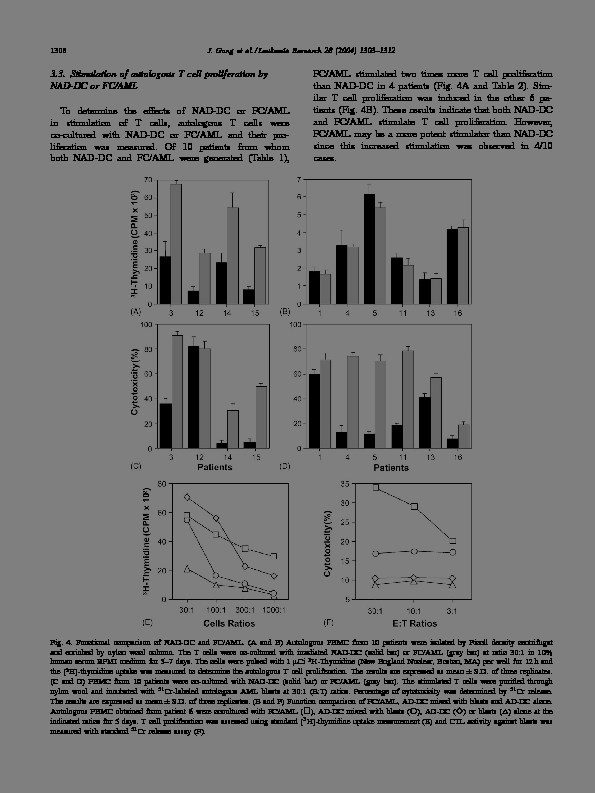

id 6 41
page size (595, 793)


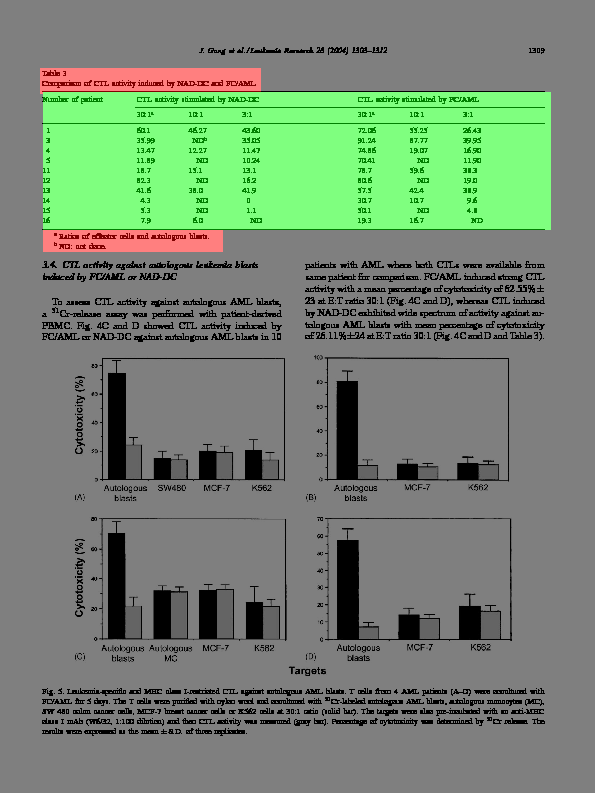

,Number,of,patient,CTL activity,Unnamed: 4,stimulated,by NAD-DC,CTL activity.1,Unnamed: 8,stimulated.1,by,FC/AML
0,NaN,NaN,NaN,30:1a,NaN,10:1,3:1,30:1a,NaN,10:1,NaN,3:1
1,1.0,NaN,NaN,60.1,NaN,46.27,43.60,72.06,NaN,55.25,NaN,26.43
2,3.0,NaN,NaN,35.99,NaN,NDb,35.05,91.24,NaN,87.77,NaN,39.95
3,4.0,NaN,NaN,13.47,NaN,12.27,11.47,74.86,NaN,19.07,NaN,16.90
4,5.0,NaN,NaN,11.89,NaN,ND,10.24,70.41,NaN,ND,NaN,11.90
5,11.0,NaN,NaN,18.7,NaN,15.1,13.1,78.7,NaN,59.6,NaN,38.3
6,12.0,NaN,NaN,82.3,NaN,ND,16.2,80.6,NaN,ND,NaN,19.0
7,13.0,NaN,NaN,41.6,NaN,38.0,41.9,57.5,NaN,42.4,NaN,38.9
8,14.0,NaN,NaN,4.3,NaN,ND,0,30.7,NaN,10.7,NaN,9.6
9,15.0,NaN,NaN,5.3,NaN,ND,1.1,50.1,NaN,ND,NaN,4.8


src box [225  41 253 224]
src conv [ 83 587 266 615]
LTPage[pageid="7"] :in_bbox("83,587,266,615")
found box (96.2881, 589.5430883, 251.70058170000004, 609.5023624)
conv back [ 230.4976376   54.2881     250.4569117  209.7005817]
cropbox [42, 47, 637, 840]
a Ratios of effector cells and autologous blasts. b ND: not done. a Ratios of effector cells and autologous blasts. b ND: not done.
src box [ 66  38  95 262]
src conv [ 80 745 304 774]
LTPage[pageid="7"] :in_bbox("80,745,304,774")
found box (84.33297352, 752.3947846, 297.70849072000016, 771.2520412)
conv back [  68.7479588    42.33297352   87.6052154   255.70849072]
cropbox [42, 47, 637, 840]
Table 3 Comparison of CTL activity induced by NAD-DC and FC/AML Table 3 Comparison of CTL activity induced by NAD-DC and FC/AML
id 7 53


/root/.pyenv/versions/3.6.0/lib/python3.6/site-packages/PIL/Image.py:888: UserWarning: Palette images with Transparency   expressed in bytes should be converted to RGBA images
  'to RGBA images')


page size (595, 793)


/root/.pyenv/versions/3.6.0/lib/python3.6/site-packages/ipykernel_launcher.py:150: RuntimeWarning: invalid value encountered in true_divide


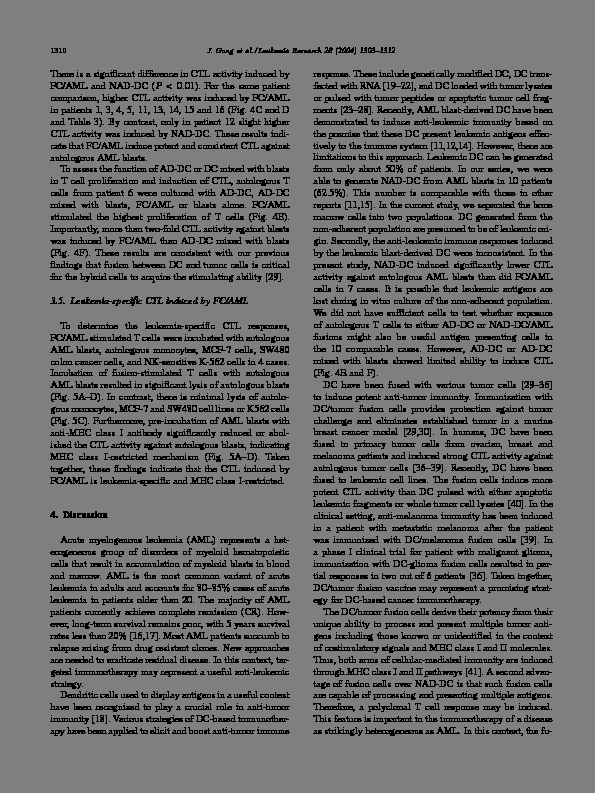

id 8 78
page size (595, 793)


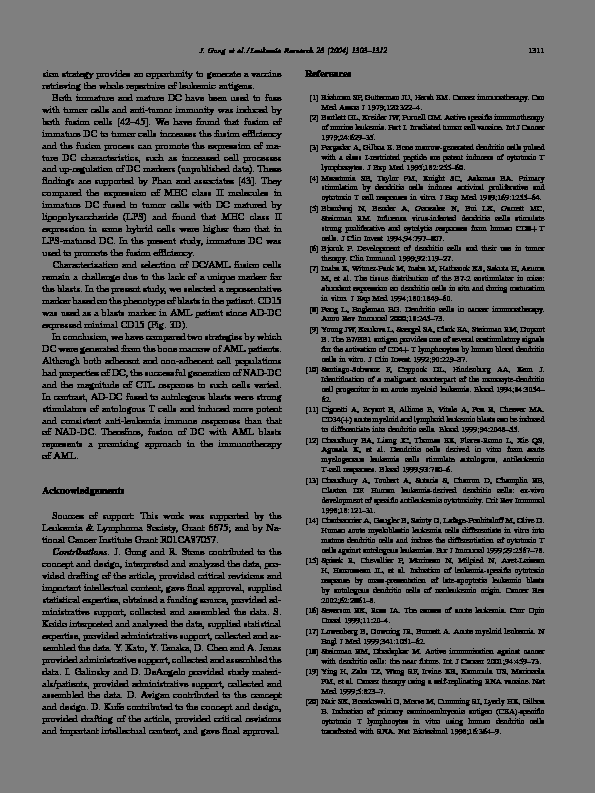

id 9 84
page size (595, 793)


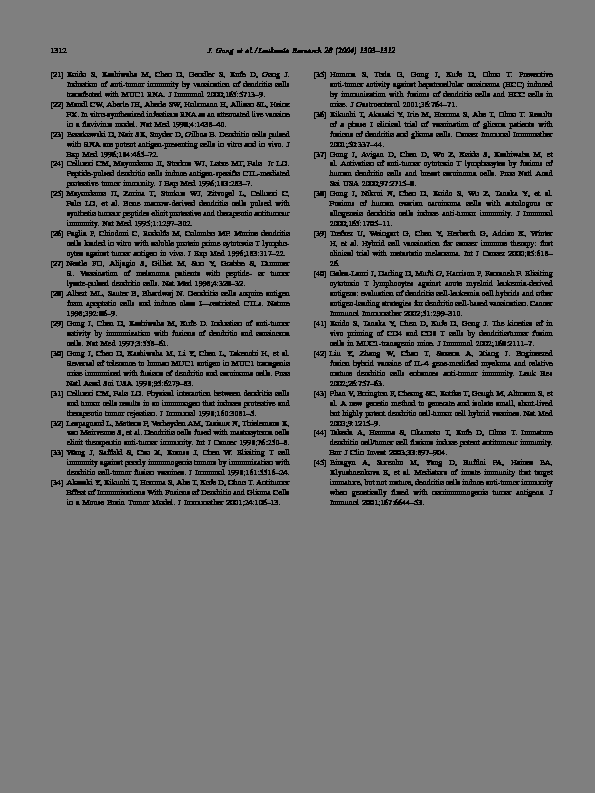

[TableInfo(page=1, surrounding_text_boxes=[array([287,  48, 323, 302]), array([ 66,  45,  95, 302])], surrounding_texts=['a Numbers in bold are samples from which NAD-DC were generated. a Numbers in bold are samples from which NAD-DC were generated.', 'Table 1 Summary of clinical data from patients with acute myelogenous leukemia Table 1 Summary of clinical data from patients with acute myelogenous leukemia'], body_box=array([ 91,  45, 291, 417]), body=        Number   Age  Sex   Diagnosis                     Cytogenetic  \
0   of samplea   NaN  NaN         NaN                             NaN   
1            1  63.0    M      AML-M2                           46 XY   
2            2  50.0    F      AML-M4               der(7) t(1:7), +8   
3            3  23.0    M      AML-M2                         t(5;15)   
4            4  31.0    F      AML-M3                        t(15;17)   
5            5  49.0    M      AML-M3                     t(15;17;19)   
6            6  45.0    F      A

In [184]:
# %%prun
process_pdf(segmentation_model, '/notebook/data/tmp/15475072.pdf')

## Vis2

In [148]:
parsed_pdf = pdfquery.PDFQuery('/notebook/data/tmp/15475072.pdf')
parsed_pdf.load()

In [149]:
q = list(parsed_pdf.get_layouts())

In [151]:
w = q[0]

In [153]:
w.

11

In [164]:
q = parsed_pdf.get_page(4)

In [138]:
list(parsed_pdf.get_layouts())

[<LTPage(21) 0.000,0.000,842.000,1191.000 rotate=0>,
 <LTPage(22) 0.000,0.000,842.000,1191.000 rotate=0>,
 <LTPage(23) 0.000,0.000,842.000,1191.000 rotate=0>,
 <LTPage(24) 0.000,0.000,842.000,1191.000 rotate=0>,
 <LTPage(25) 0.000,0.000,842.000,1191.000 rotate=0>,
 <LTPage(26) 0.000,0.000,842.000,1191.000 rotate=0>,
 <LTPage(27) 0.000,0.000,842.000,1191.000 rotate=0>,
 <LTPage(28) 0.000,0.000,842.000,1191.000 rotate=0>,
 <LTPage(29) 0.000,0.000,842.000,1191.000 rotate=0>,
 <LTPage(30) 0.000,0.000,842.000,1191.000 rotate=0>]

In [135]:
q.pageid

18

In [95]:
convert_coords_to_pq(header_box, q.mediabox[-1])

array([  45, 1096,  302, 1125])

In [160]:
parsed_pdf.pq('LTPage[pageid="2"] :in_bbox("45,745,302,774")')[0].layout.bbox

(92.4521, 762.3574096, 116.9362472, 771.2520412)

In [113]:
convert_coords_to_pq(header_box, q.cropbox[-1])

array([ 45, 745, 302, 774])

In [100]:
res = parsed_pdf.pq('LTPage[pageid="2"] :contains("Table")')

In [107]:
w = res[0] #.xpath('.//text()')

In [165]:
convert_coords_from_pq((92.4521, 762.3574096, 116.9362472, 771.2520412), q.cropbox[-1])

array([  68.7479588,   92.4521   ,   77.6425904,  116.9362472])

In [60]:
'LTPage[pageid={}] :overlaps_bbox("{},{},{},{}")'.format(1,
                                                                       header_box[1],
                                                                       header_box[0],
                                                                       header_box[3],
                                                                       header_box[2])

'LTPage[pageid=1] :overlaps_bbox("45,91,417,291")'

In [42]:
q.cropbox

[42, 47, 637, 840]

In [45]:
q.mediabox

[0, 0, 842, 1191]

In [63]:
842 - 817

25

In [95]:
# page_filenames = pdf_to_pages('/notebook/data/tmp/11427731.pdf', '/notebook/data/tmp/pages')
table_coords = process_page(segmentation_model, '/notebook/data/tmp/pages/0002.png', '/notebook/data/tmp/pages/page_buf/',
                            mask_threshold=0.5)
table_coords

FileNotFoundError: [Errno 2] No such file or directory: '/notebook/data/tmp/pages/0002.png'